In [2]:
import pandas as pd          #For dataframe related operations
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
import datetime as dt  # To access datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
#This is preprocessing and reading of file which would be avoided as the file size is too high thus 
# takes a lot of time to load. We would instead use summarized version of the file as done below.
raw = pd.read_csv('rides.csv',parse_dates=['EntryDateTime','ExitDateTime'])
raw.info()
raw.head()
raw_dp=raw.drop(['TripNumber','LicensePlate','PickupDropoffDateTime','MatchedRide','MultiPartyTrips','LongitudeLatitude','EGGRGramsCO2PerMile','GGR','NumberOfParties'],axis=1)
raw_dp.info()
raw_dp['Count']=1


C:\Users\harsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw_dp=pd.read_csv('Rideshare_timeseries.csv',parse_dates=['EntryDateTime','ExitDateTime'])

In [6]:
raw_ts=raw_dp[['EntryDateTime','Count']]

In [7]:
raw_ts.index=raw_ts.EntryDateTime
raw_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 920377 entries, 2018-04-30 22:53:00 to 2018-06-30 23:46:00
Data columns (total 2 columns):
EntryDateTime    917448 non-null datetime64[ns]
Count            920377 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 21.1 MB


In [8]:
hourly_raw = raw_ts.resample('H').sum()

In [10]:
hourly_raw['TimeStamp']=pd.to_datetime(hourly_raw.index)
hourly_raw=hourly_raw[['TimeStamp','Count']]
hourly_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5049 entries, 2017-12-02 15:00:00 to 2018-06-30 23:00:00
Data columns (total 2 columns):
TimeStamp    5049 non-null datetime64[ns]
Count        5049 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 118.3 KB


In [11]:
hourly_raw.head()

,TimeStamp,Count
EntryDateTime,,
2017-12-02 15:00:00,2017-12-02 15:00:00,478
2017-12-02 16:00:00,2017-12-02 16:00:00,2531
2017-12-02 17:00:00,2017-12-02 17:00:00,1374
2017-12-02 18:00:00,2017-12-02 18:00:00,1468
2017-12-02 19:00:00,2017-12-02 19:00:00,1280


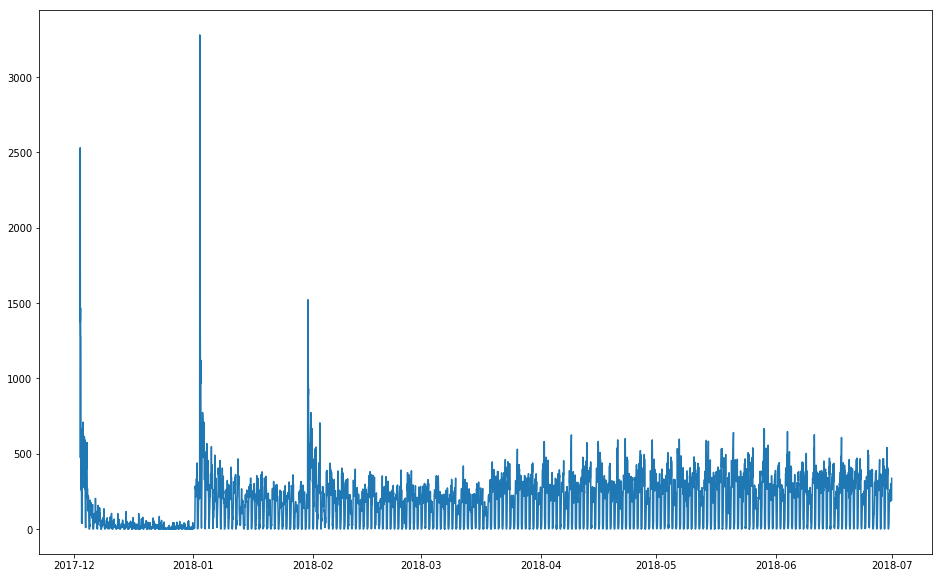

In [15]:
plt.figure(figsize=(16,10))
plt.plot(hourly_raw.Count)

#### Observation:
From the above model we can see a very strong seasonal pattern from Jan onwards till July. We also see two big outliers one in the month of december and another in the first week of Jan. Practically thinking, they appear to be present because of a lot of people travelling for christmas in december and travelling back in January first week! There is also an unexplained outlier in February first week, we may need more granular level analysis to understand what could have caused that!

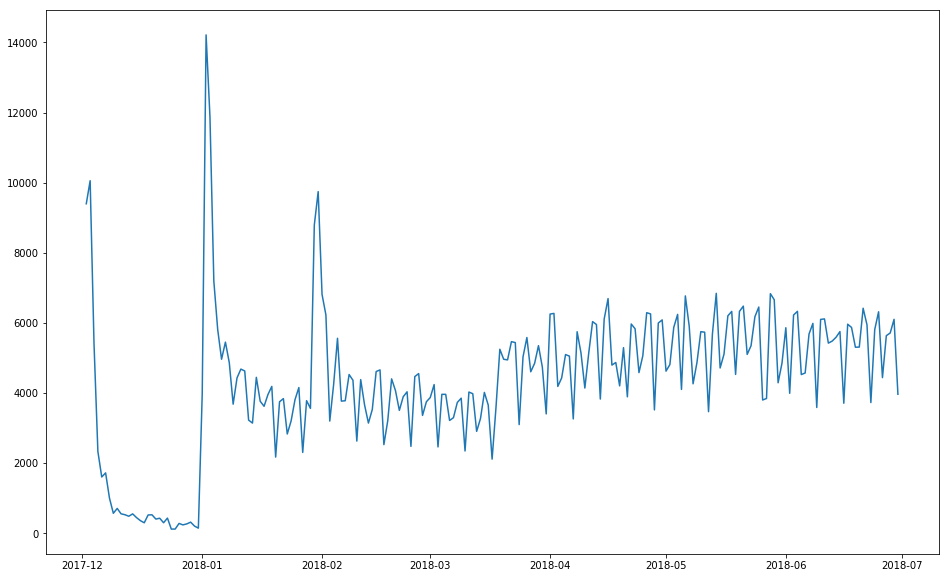

In [13]:
# To limit the noise from the above plot, let's try a daily summarized plot for the above. This is a 
# perfect example of downsampling.

daily_raw = hourly_raw.resample('D').sum()
plt.figure(figsize=(16,10))

plt.plot(daily_raw)

### Hypothesis:
1. As the timeseries dataset is related to ridesharing at the san diego airport, i assume that the traffic around airport would be more during weekdays mainly for business travel and people travelling for leisure prefer to choose weekdays as they are cheaper. Let's assume that to be one hypothesis. ( check the relationship between independent variable Weekdays vs. dependent variable ride count)

2. The traffic activity would be greater during holiday seasons like around christmas time or thanksgiving. Let's assume that to be another hypothesis that we can expect more traffic around holiday season.

3. We can assume that the traffic should show strong seasonal patterns except for the holiday season. 

4. Expect more traffic during morning or night hours as those flights tend to be cheaper. ( check the relationship between independent variable time of the day/ Hour vs. dependent variable ride count)

### Feature creation

From the above hypothesis we can understand that we need more variables to make better understanding of the data to see if our hyptothesis are true or false 


In [48]:
# Lets breakdown the given timeseries object in year,month,day and hour to create more features thus
# simplifying the prediction process further
    
hourly_raw['year']= [x.year for x in hourly_raw["TimeStamp"]]
hourly_raw['month']= [x.month for x in hourly_raw["TimeStamp"]]
hourly_raw['day']= [x.day for x in hourly_raw["TimeStamp"]]
hourly_raw['hour']= [x.hour for x in hourly_raw["TimeStamp"]]

#Lets now get the day of the week
hourly_raw['day of week']=hourly_raw['TimeStamp'].dt.dayofweek+1

#Lets get a column stating if the given date belongs to a weekend(1) or a weekday(0)
def weekend_check(row):
    if row ==6 or row ==7:
        return 1
    else:
        return 0

hourly_raw['weekend']=hourly_raw['day of week'].apply(weekend_check)    


In [18]:
hourly_raw.head()

,TimeStamp,Count,year,month,day,hour,day of week,weekend
EntryDateTime,,,,,,,,
2017-12-02 15:00:00,2017-12-02 15:00:00,478,2017,12,2,15,6,0
2017-12-02 16:00:00,2017-12-02 16:00:00,2531,2017,12,2,16,6,0
2017-12-02 17:00:00,2017-12-02 17:00:00,1374,2017,12,2,17,6,0
2017-12-02 18:00:00,2017-12-02 18:00:00,1468,2017,12,2,18,6,0
2017-12-02 19:00:00,2017-12-02 19:00:00,1280,2017,12,2,19,6,0


In [50]:
hourly_raw.tail()

,TimeStamp,Count,year,month,day,hour,day of week,weekend
EntryDateTime,,,,,,,,
2018-06-30 19:00:00,2018-06-30 19:00:00,244,2018,6,30,19,6,1
2018-06-30 20:00:00,2018-06-30 20:00:00,303,2018,6,30,20,6,1
2018-06-30 21:00:00,2018-06-30 21:00:00,189,2018,6,30,21,6,1
2018-06-30 22:00:00,2018-06-30 22:00:00,192,2018,6,30,22,6,1
2018-06-30 23:00:00,2018-06-30 23:00:00,337,2018,6,30,23,6,1


Now that we have got our data ready, let's perform some exploratory data analysis.

### Exploratory Data Analysis:

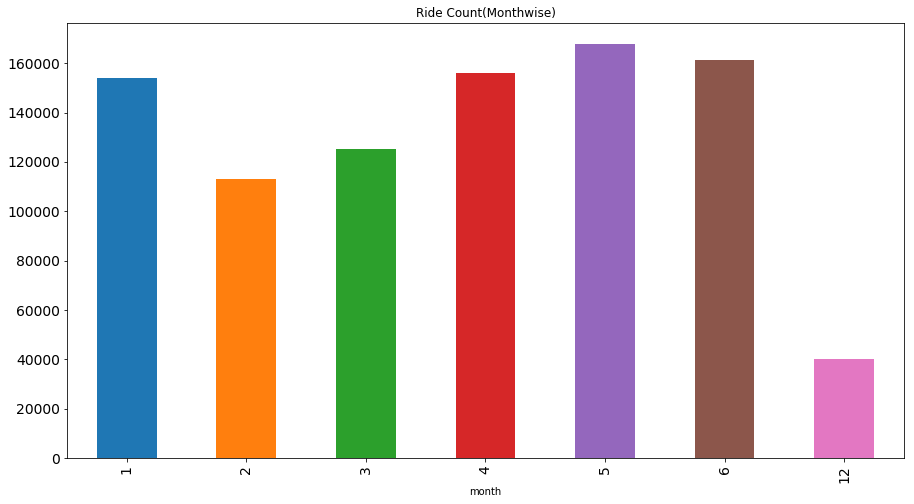

In [26]:
# Month wise count plot to check for seasonality if any

hourly_raw.groupby('month')['Count'].sum().plot.bar(figsize=(15,8), title= 'Ride Count(Monthwise)', fontsize=14)

### Observation:
We see an interesting behaviour of large number of rides being done in Jan (vacation returning crowd) and during summer time(Summer break travellers) which is belivable. The chart however would have been more interesting if we would have had more data!!


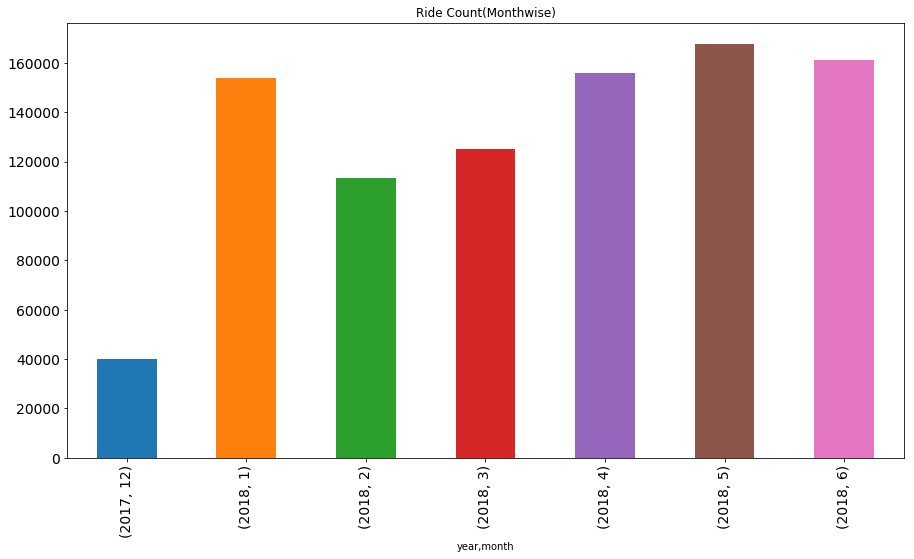

In [25]:
#This shall produce a same visual like above as we have limited amount of data. Here however we are
# trying to see grouping year as well as month wise.

temp=hourly_raw.groupby(['year', 'month'])['Count'].sum()
temp.plot.bar(figsize=(15,8), title= 'Ride Count(Monthwise)', fontsize=14)

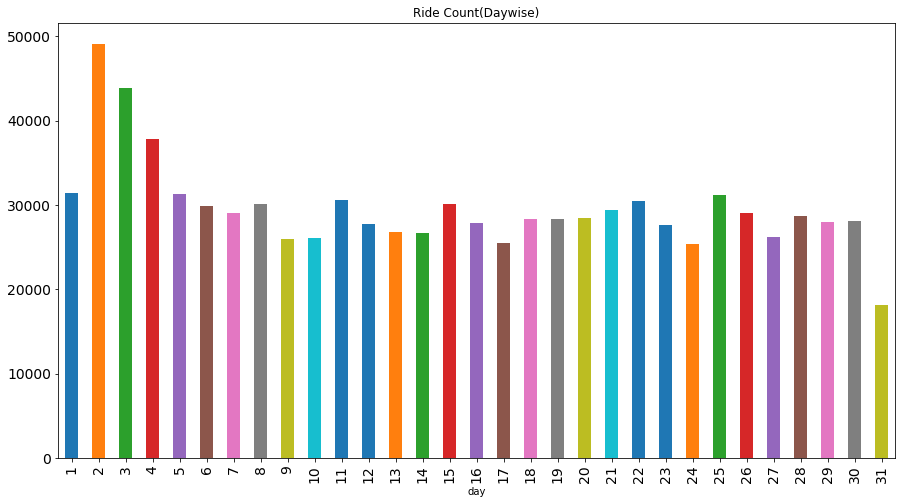

In [59]:
# Let's get more granular and check the daywise ride count trend

hourly_raw.groupby(['day'])['Count'].sum().plot.bar(figsize=(15,8), title= 'Ride Count(Daywise)', fontsize=14)

### Observation:
There isn't a solid distinguishing features from the above chart but we can say that there are a lot of 
rides around airport in the beginning of the month and the seasonal pattern is strong.

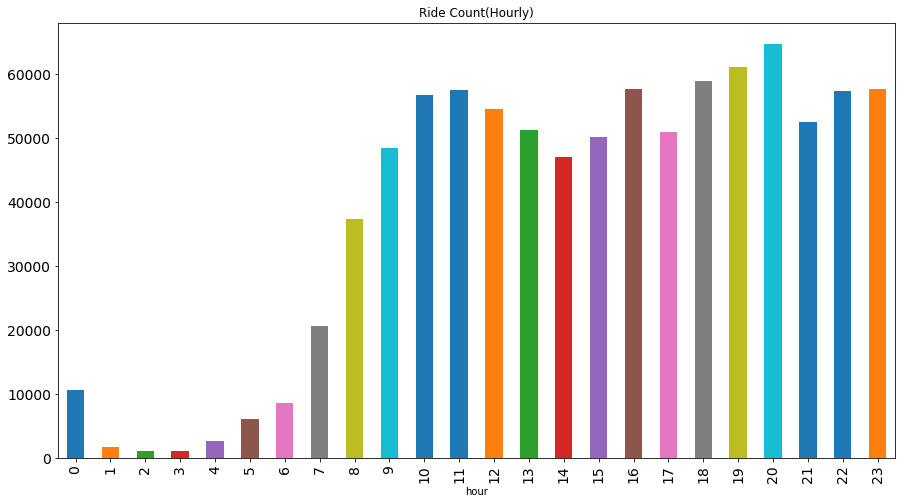

In [57]:
hourly_raw.groupby('hour')['Count'].sum().plot.bar(figsize=(15,8), title= 'Ride Count(Hourly)', fontsize=14)

### Observation:

Our fourth hypothesis seems to be true as we see great traffic around morning and night time. Any cab driver would be beneficial by looking at the above plot as it helps in understanding the peak traffic hours around the airport!

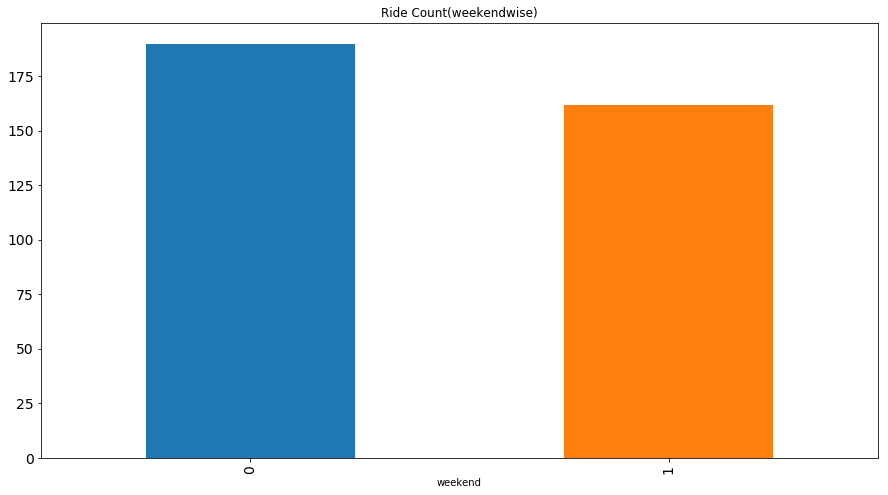

In [55]:
# Now lets check the traffic of weekdays vs weekends!

hourly_raw.groupby('weekend')["Count"].mean().plot.bar(figsize=(15,8), title= 'Ride Count(weekendwise)', fontsize=14)

### Observation:

From the above plot we can confirm another hypothesis to expect more traffic around weekdays due to relatively cheaper fair. We chose mean instead of sum in the above scenario as we have 5 weekdays compared to 2 weekend days thus mean would be a better choice for better understanding of the timeseries trend.

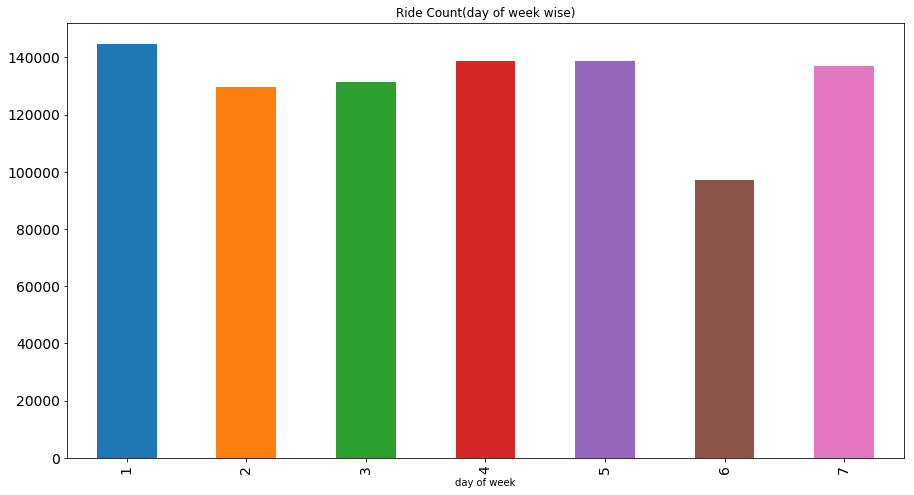

In [63]:
#Lets breakdown the above into individual days.

hourly_raw.groupby('day of week')['Count'].sum().plot.bar(figsize=(15,8), title= 'Ride Count(day of week wise)', fontsize=14)

### Observation: 
For above we can choose sum instead of mean as they are individual day measures

### Forecasting Model Building

So far we understood a lot about the data we have and also realized some of the trends like what are the peak hours and whats the best time to be at the airport. Now let's do some modelling to understand if we can predict how the future traffic is going to be at the airport.

Our timeseries data was very granular having ride details per second. Plotting and working with such granular data can be noisy and time consuming thus for simplification we would work with the summarized hourly data. We have already upsampled our data and we shall start building our model with that!

In [73]:
hourly_raw['TimeStamp'].min() , hourly_raw['TimeStamp'].max()

(Timestamp('2017-12-02 15:00:00'), Timestamp('2018-06-30 23:00:00'))

In [92]:
#Lets split the data in training and test. As seen above we have very small data set thus we are going
# to stick to 90-10 train-test split. And we would adjust the split depending upon how the model performs.
train = hourly_raw.loc['2017-12-02':'2018-06-10']
test=hourly_raw.loc['2018-06-10':]

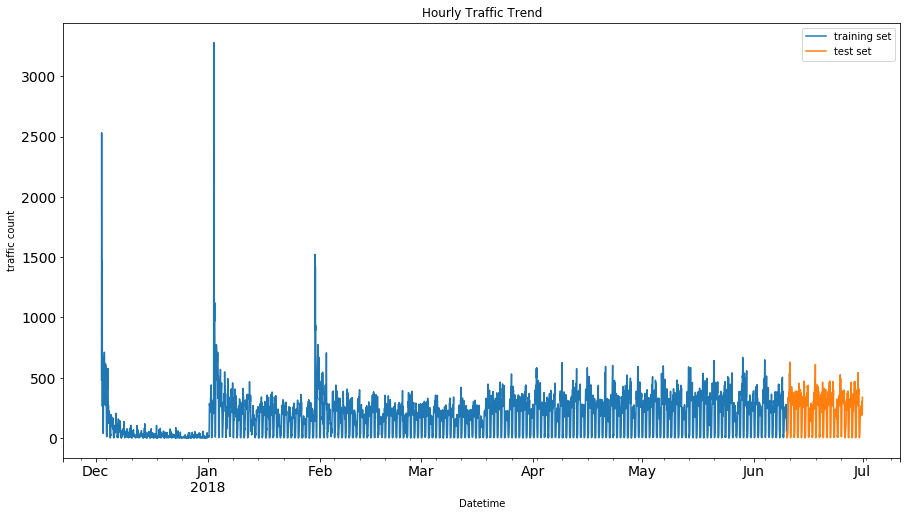

In [97]:
train.Count.plot(figsize=(15,8), title= 'Hourly Traffic Trend', fontsize=14, label='training set')
test.Count.plot(figsize=(15,8), title= 'Hourly Traffic Trend', fontsize=14, label='test set')
plt.xlabel("Datetime")
plt.ylabel("traffic count")
plt.legend()
plt.show()

In [120]:
#As the above plot looks very noisy lets try to upsample a bit more to daily level, we would downsample
# it later on finalizing the model.
daily_raw=raw_ts.resample('D').sum()

In [121]:
train = daily_raw.loc['2017-12-02':'2018-06-05']
test=daily_raw.loc['2018-06-05':]

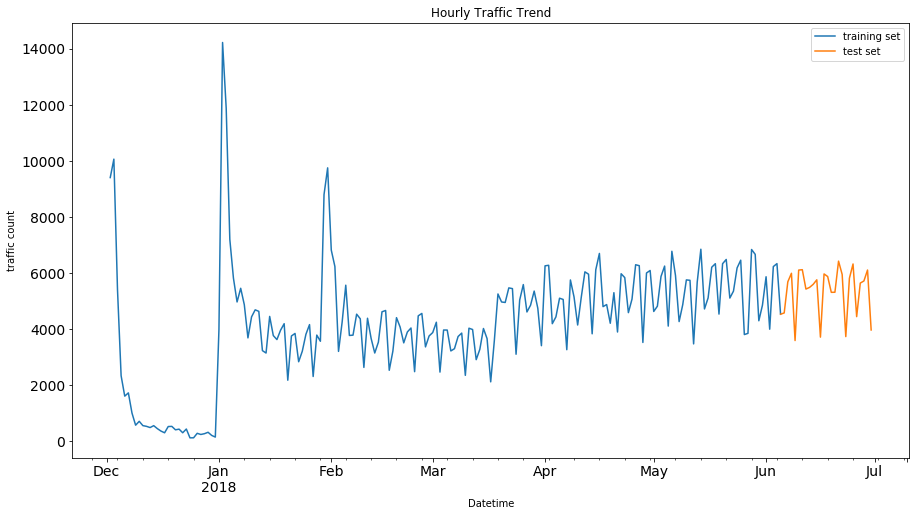

In [122]:
train.Count.plot(figsize=(15,8), title= 'Hourly Traffic Trend', fontsize=14, label='training set')
test.Count.plot(figsize=(15,8), title= 'Hourly Traffic Trend', fontsize=14, label='test set')
plt.xlabel("Datetime")
plt.ylabel("traffic count")
plt.legend()
plt.show()